In [11]:
import numpy as np
from furl import Path
from sklearn.metrics import r2_score
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
from typing import Sequence
!conda install --yes --prefix {sys.prefix} trains
from trains import Task

/bin/sh: 1: conda: not found


In [13]:
EPS = 3
FONT_SIZE = 14

In [14]:
def to_minimize(fun):
    """
    In order to 
    :param fun: predictor function
    :return: function calculated output - function predicted output 
    """
    return lambda w, x, y: fun(w, x) - y


def log_predictor(x: list, t: int, eps: int=EPS)->float:
    """
    Logarithmic regression model.
    :param x: Vector of the model weights.
    :param t: The model explanatory variable.
    :param eps: Epsilon, for numerical stability
    :return: Prediction of the model given (t;x)
    """
    return np.log(t + eps) * x[0] + x[1]


def log_log_predictor(x, t, eps=EPS)->float:
    """
    Log-Logarithmic regression model.
    :param x: Vector of the model weights.
    :param t: The model explanatory variable.
    :param eps: Epsilon, for numerical stability
    :return: Prediction of the model given (t;x)
    """
    return np.log(np.log(t + eps)) * x[0] + x[1]


def log_log_log_predictor(x, t, eps=EPS)->float:
    """
    Log-Log-Logarithmic regression model.
    :param x: Vector of the model wights.
    :param t: The model explanatory variable.
    :param eps: Epsilon, for numerical stability
    :return: Prediction of the model given (t;x)
    """
    return np.log(np.log(np.log(t + eps))) * x[0] + x[1]


def pareto_predictor(x, t, eps=EPS)->float:
    """
    Pareto CDF used a regression model.
    :param x: Vector of the model weights.
    :param t: The model explanatory variable.
    :param eps: Epsilon, for numerical stability
    :return: Prediction of the model given (t;x)
    """
    return 1 - np.power(1 / (t + eps), x[0])


def generelised_pareto_predictor(x, t, eps=EPS)->float:
    """
    Generalisation of the Pareto CDF as a regression model, to 3 learnable parameters, instead of 1.
    :param x: Vector of the model weights.
    :param t: The model explanatory variable.
    :param eps: Epsilon, for numerical stability
    :return: Prediction of the model given (t;x)
    """
    return x[0] - x[1] * np.power(1 / (t + eps), x[2])


def arm_predictor(x, t)->float:
    """
    Asymproric regression model
    :param x: Vector of the model weights.
    :param t: The model explanatory variable.
    :return: Prediction of the model given (t;x)
    """
    return x[2] - x[0] * np.exp(-x[1] * t)


def poly_log_predictor(t, x, eps=EPS)->float:
    """
    Polynome on the explanatory variable after a log transformation.
    :param x: Vector of the model wights.
    :param t: The model explanatory variable.
    :param eps: Epsilon, for numerical stability
    :return: Prediction of the model given (t;x)
    """
    return np.log(eps + t * x[0]) * x[1] + np.log(eps + t * x[2]) * x[3]


def multi_log_predictor(x, t, eps=EPS) -> float:
    """
    A model combining logarithmic regression and log-logarithmic regressoin.
    :param x: Vector of the model weights.
    :param t: The model explanatory variable.
    :param eps: Epsilon, for numerical stability
    :return: Prediction of the model given (t;x)
    """
    return np.log(eps + t * x[0]) * x[1] + np.log(np.log(eps + t * x[0])) * x[1]


In [15]:
def fit_and_predict(
        predictor, train_samples: np.ndarray, t: np.ndarray, y: np.ndarray
):
    """
    Fit the function parameters based on 
    the first 'num_of_predictions' and predict the values
    (usually mAP for object detection tasks)
    for all of the data.   
    :param predictor: The function prediction the values (mAP)
    :param train_samples: Which of the training samples
    will be used to train the predictor.
    :param t: The training set size (Explanatory variable).
    :param y: The values (Response variable).
    :param x0: Initial guess of the predictor parameters.
    :return: 
    """
    x0=np.array([0.4, 0.01, 0.4, 0.1])
    fun = to_minimize(predictor)
    t_train, y_train = t[train_samples], y[train_samples]
    trained_predictor = least_squares(
        fun, x0, args=(t_train, y_train))
    y_predictions = predictor(trained_predictor.x, t)
    return y_predictions, trained_predictor

    
def plot_predictions(
    predictor,
    csv_filepath: Path,
    network_names: Sequence[str]=["MobileNet v2", "ResNet 101"],
    predictor_name: str="Logarithmic predictor",
    train_samples=np.arange(4),
):
    """
    Predict and plot the diminishing returns dynamics.
    :param predictor: model predicting the diminishing returns dymanics.
    :param csv_filepath: path to a csv path. In this csv file, column #1 should be the subset size,
    column #2 the ground truth of the first detector and coloum #3 - the ground truth of the second
    detector, if any.
    :param network_names: Names of models used for detection.
    :param predictor_name: Name of the diminishing returns dynamic predictor.
    :param train_samples: Which samples of the data should be used to tweak the predictor parameters.
    """
    colors = ["g", "b", "c", "m", "y", "r", "b"]
    colors = colors[: len(network_names)]
    r_sqr_array = []
    csv_file = pd.read_csv(csv_filepath)
    t_train = np.array(csv_file[csv_file.columns[1]])
    mobilenet_train = np.array(csv_file[csv_file.columns[2]])
    resnet_train = np.array(csv_file[csv_file.columns[3]])
    plt.rc("font", size=FONT_SIZE)  # controls default text sizes
    plt.rc("axes", titlesize=FONT_SIZE)  # fontsize of the axes title
    plt.rc("axes", labelsize=FONT_SIZE)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=FONT_SIZE)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=FONT_SIZE)  # fontsize of the tick labels
    plt.rc("legend", fontsize=FONT_SIZE)  # legend fontsize
    plt.rc("figure", titlesize=FONT_SIZE)  # fontsize of the figure title
    for y_train, network_name, color in zip(
        [mobilenet_train, resnet_train], network_names, colors
    ):
        y_predicted, fitted_predictor = fit_and_predict(
            predictor=predictor, train_samples=train_samples, t=t_train,
            y=y_train
        )
        plt.plot(
            t_train,
            y_predicted,
            color=color,
            label=f"Predictions, {network_name}".format(),
        )
        plt.plot(
            t_train,
            y_train,
            color=color,
            linestyle="--",
            label=f"Ground truth, {network_name}".format(),
        )
        plt.plot(t_train[train_samples], y_train[train_samples], "o", color=color)
        r_sqr_array.append(r2_score(y_train, y_predicted))

    plt.xlabel("Data volume")
    plt.ylabel("mAP")
    r_sqr_string = [
        f"{network_name}: {str(r_squr)[:5]}"
        for network_name, r_squr in zip(network_names, r_sqr_array)
    ]
    r_sqr_string = "; ".join(r_sqr_string)
    plt.title(predictor_name + ". R sqr: " + "\n" + r_sqr_string)
    plt.legend()
    plt.savefig(f"{predictor_name}.png", format="png", dpi=1000)
    plt.show()

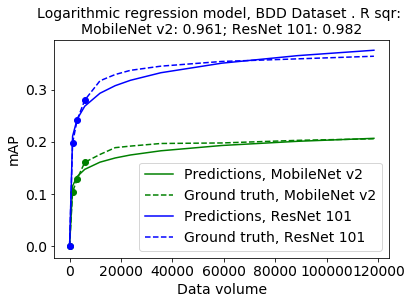

In [10]:
csv_filepath = "path/to/diminishing returns results.csv"
csv_file = pd.read_csv(csv_filepath)
t_train = np.array(csv_file[csv_file.columns[1]])
y_train = np.array(csv_file[csv_file.columns[2]])

plot_predictions(
predictor=log_predictor,
csv_filepath=csv_filepath,
train_samples=np.arange(4),
predictor_name="Logarithmic regression model, BDD Dataset ",
)
